<h2 style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Diabetes Prediction
</h2>

- **About the author:** Sajjad Ali Shah
- **LinkedIn:** [LinkedIn Profile](https://www.linkedin.com/in/sajjad-ali-shah47/)
- **Dataset link:** [Diabetes Dataset](https://www.kaggle.com/datasets/johndasilva/diabetes)

---

<a id="library"></a>
<div style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Import Libraries
    </h2>
</div>


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [119]:
df=pd.read_csv("./dataset/diabetes.csv")

In [120]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [121]:
df.shape

(2000, 9)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [123]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [124]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [125]:
df.duplicated().sum()

1256

<div style="border: 2px solid #78B7D0; border-radius: 10px; padding: 15px;;">
    <h3>🔍 Observations:</h3>
    <ul>
        <li>📊 <strong>There are 2000 rows and 9 columns</strong> in our data.</li>
        <li>🔢 <strong>All columns are of numerical type</strong>.</li>
        <li>📈 <strong>No missing values in our data</strong>.</li>
    </ul>
</div>


<a id="exploredata"></a>
<div style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Explore Data
    </h2>
</div>


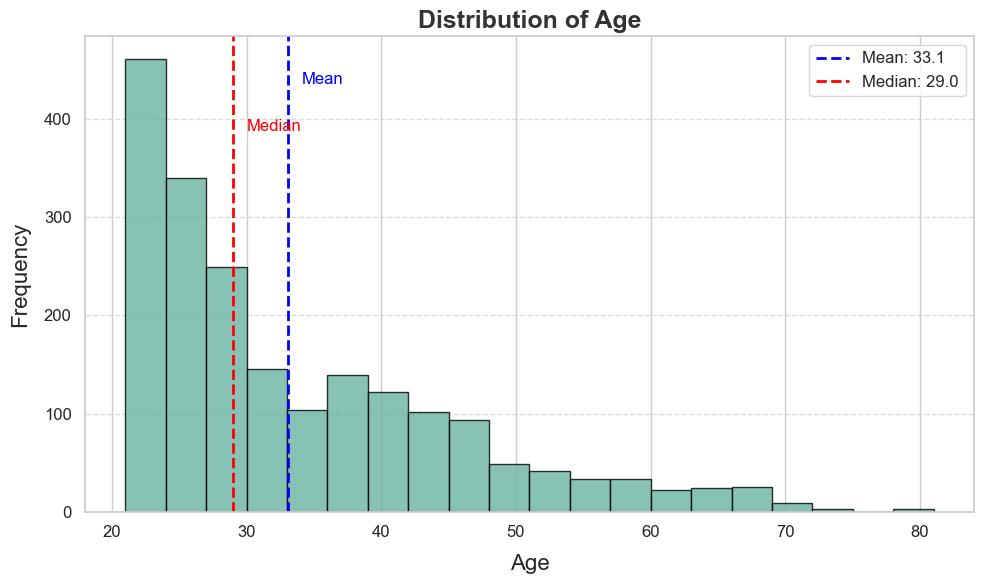

In [126]:
mean_age = df["Age"].mean()
median_age = df["Age"].median()

# Create the histogram
plt.figure(figsize=(10, 6))  # Set a larger figure size for better visualization
plt.hist(df["Age"], bins=20, color='#69b3a2', edgecolor='black', alpha=0.8)

# Add mean and median lines
plt.axvline(mean_age, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.1f}')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set the title and labels
plt.title('Distribution of Age', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Age', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16, labelpad=10)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, frameon=True)

# Add annotations for key statistics
plt.text(mean_age + 1, plt.ylim()[1] * 0.9, 'Mean', color='blue', fontsize=12)
plt.text(median_age + 1, plt.ylim()[1] * 0.8, 'Median', color='red', fontsize=12)

# Show the plot
plt.tight_layout()  
plt.show()


<div style="border: 2px solid #78B7D0; border-radius: 10px; padding: 15px;">
  <h2>📋 Observations:</h2>
  <ul>
    <li>📊 The <strong>histogram illustrates the Age distribution</strong> in the dataset.</li>
    <li>📐 The <strong>mean age is 33.1 years</strong>, marked by the blue dashed line.</li>
    <li>📍 The <strong>median age is 29 years</strong>, indicated by the red dashed line.</li>
    <li>📈 The <strong>distribution is right-skewed</strong>, with a peak concentration between 20 and 30 years.</li>
  </ul>
</div>


In [127]:
grouped_data = df.groupby("BMI Category")["BMI"].count()

# Sort the grouped data in descending order
grouped_data_sorted = grouped_data.sort_values(ascending=False)

# Create a bar plot for the BMI category distribution
plt.figure(figsize=(8, 6))
bars = grouped_data_sorted.plot(kind='bar', color='#69b3a2', edgecolor='black')

# Add the values on top of each bar
for i, value in enumerate(grouped_data_sorted):
    plt.text(i, value + 10, str(value), ha='center', fontsize=12, fontweight='bold', color='black')

# Set the title and labels with better formatting
plt.title('BMI Category Distribution ', fontsize=18, fontweight='bold', color='#2b3e50')
plt.xlabel('BMI Category', fontsize=14, fontweight='bold', color='#2b3e50')
plt.ylabel('Values', fontsize=14, fontweight='bold', color='#2b3e50')

# Display the plot with tight layout
plt.tight_layout()
plt.show()


KeyError: 'BMI Category'

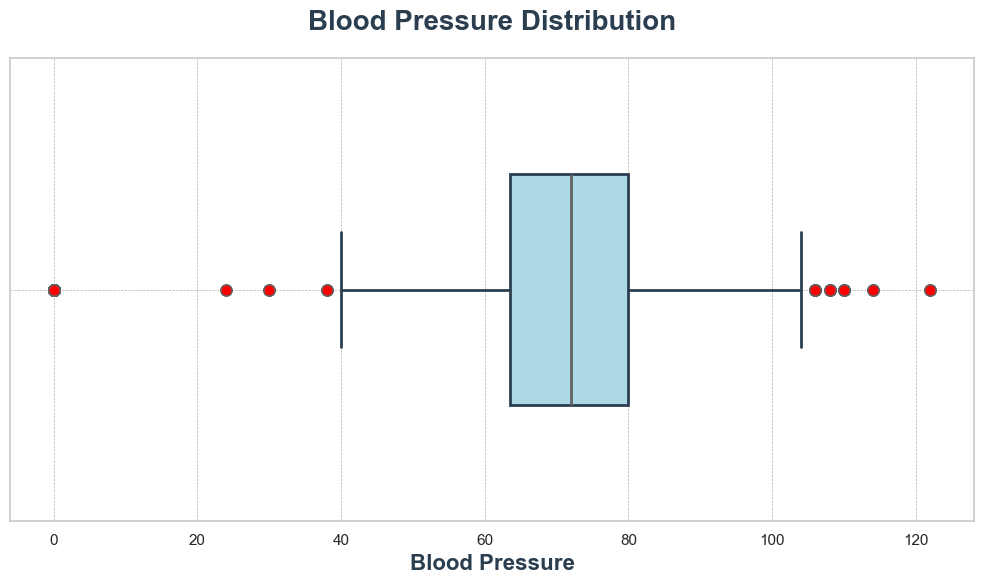

In [ ]:
sns.set(style="whitegrid")

# Create a figure and set size
plt.figure(figsize=(10, 6))

# Create the box plot for the 'BloodPressure' column with improved styling
sns.boxplot(data=df, x='BloodPressure', 
            color='#FF6347', 
            width=0.5, 
            fliersize=8, 
            linewidth=2, 
            boxprops=dict(facecolor='lightblue', edgecolor='#2b3e50'),
            whiskerprops=dict(color='#2b3e50', linewidth=2),
            capprops=dict(color='#2b3e50', linewidth=2),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=8))

# Set the title and labels with custom font size and weight
plt.title('Blood Pressure Distribution', fontsize=20, fontweight='bold', color='#2b3e50', pad=20)
plt.xlabel('Blood Pressure', fontsize=16, fontweight='bold', color='#2b3e50')

# Add gridlines for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# plt.hist(df["DiabetesPedigreeFunction"].values)
df["Glucose"]

0       138
1        84
2       145
3       135
4       139
       ... 
1995     75
1996    179
1997     85
1998    129
1999     81
Name: Glucose, Length: 2000, dtype: int64

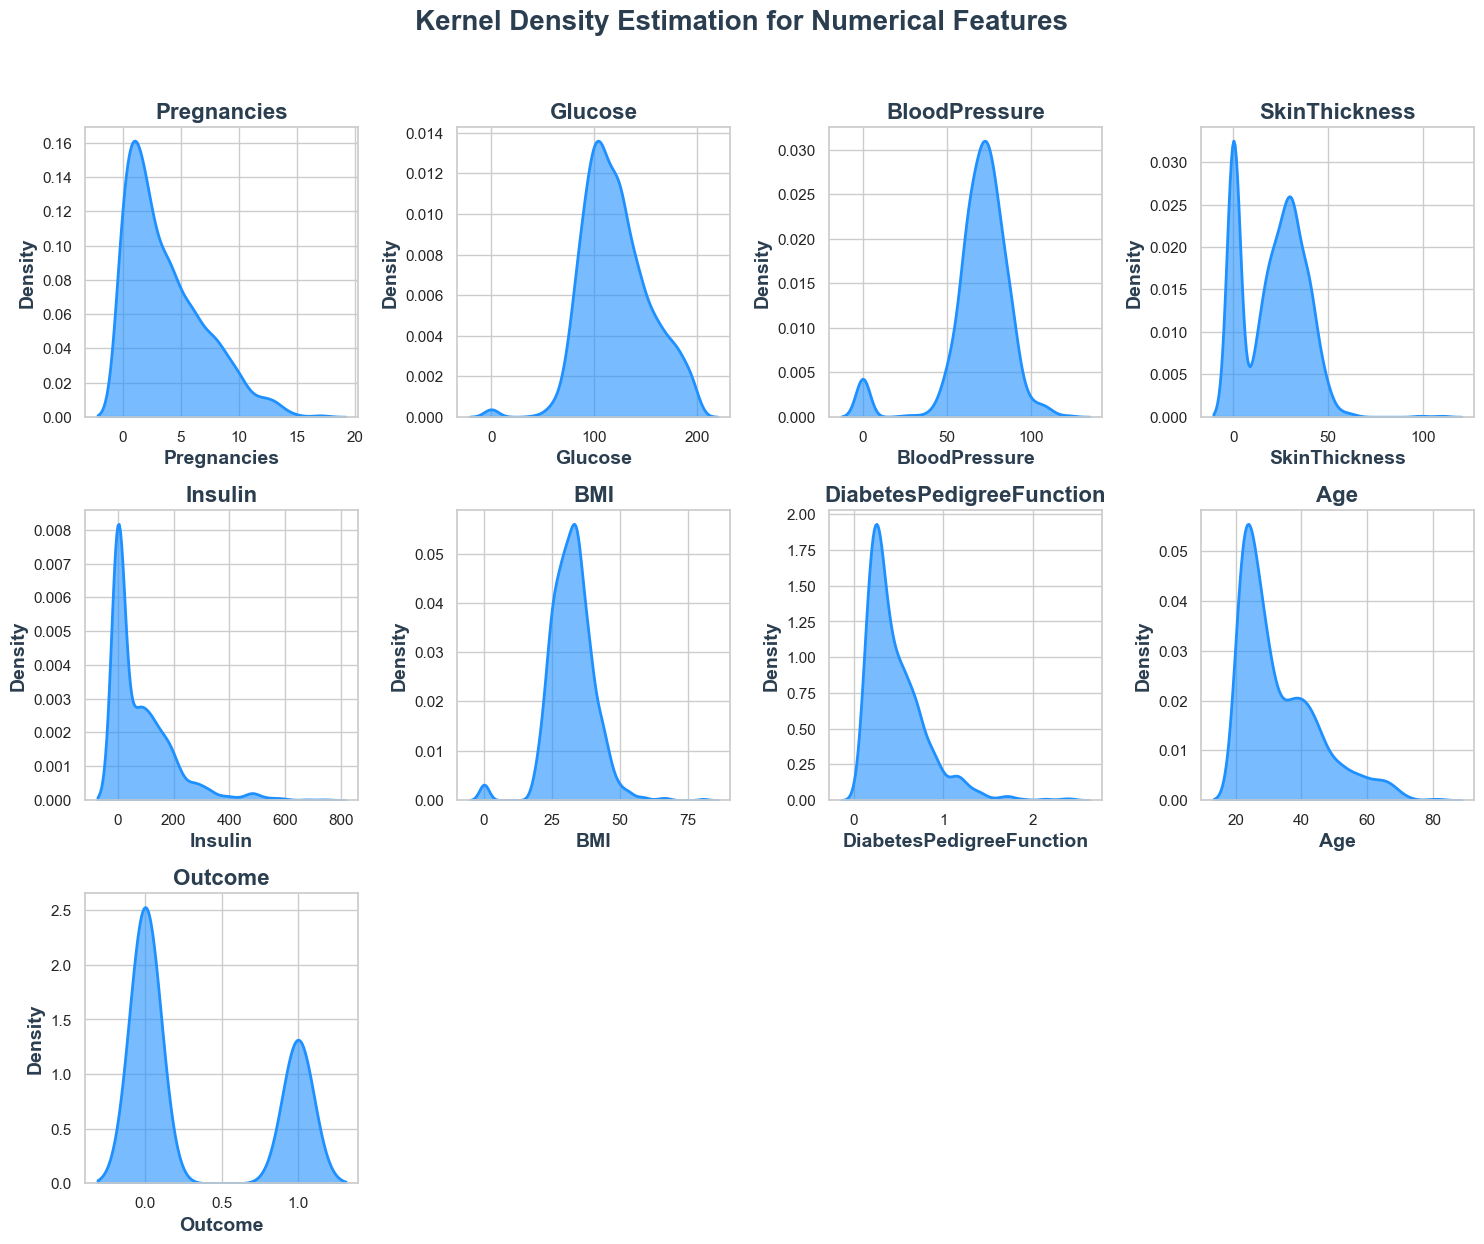

In [ ]:
sns.set(style="whitegrid", palette="muted")

# Create a figure with appropriate size
plt.figure(figsize=(15, 15))

# Iterate over each numerical column and create a KDE plot
for idx, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(4, 4, idx)  # Adjust grid size based on the number of columns
    sns.kdeplot(df[column], shade=True, color='dodgerblue', alpha=0.6, linewidth=2)  # Clean color and alpha
    plt.title(f'{column}', fontsize=16, fontweight='bold', color='#2b3e50')  # Title with color
    plt.xlabel(column, fontsize=14, fontweight='bold', color='#2b3e50')  # Axis labels
    plt.ylabel('Density', fontsize=14, fontweight='bold', color='#2b3e50')

# Adjust layout for better readability
plt.tight_layout()

# Display the plot with a polished touch
plt.suptitle('Kernel Density Estimation for Numerical Features', fontsize=20, fontweight='bold', color='#2b3e50', y=1.05)
plt.show()


In [128]:
df.columns 

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [129]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (1600, 8), X_test size: (400, 8)


In [130]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [131]:
# Using GridSearchCV to find the best algorithm for this problem
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [132]:
# Creating a function to calculate best model for this problem
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        }

    }
    
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

find_best_model(X_train, y_train)

,model,best_parameters,score
0,logistic_regression,{'C': 5},0.763125
1,decision_tree,"{'criterion': 'gini', 'max_depth': 10}",0.899375
2,random_forest,{'n_estimators': 50},0.951875
3,svm,"{'C': 20, 'kernel': 'rbf'}",0.869375


In [133]:
# Using cross_val_score for gaining average accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(n_estimators=20, random_state=0), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(scores)*100/len(scores)), 3))

Average Accuracy : 95%


In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[272,   0],
       [  2, 126]], dtype=int64)

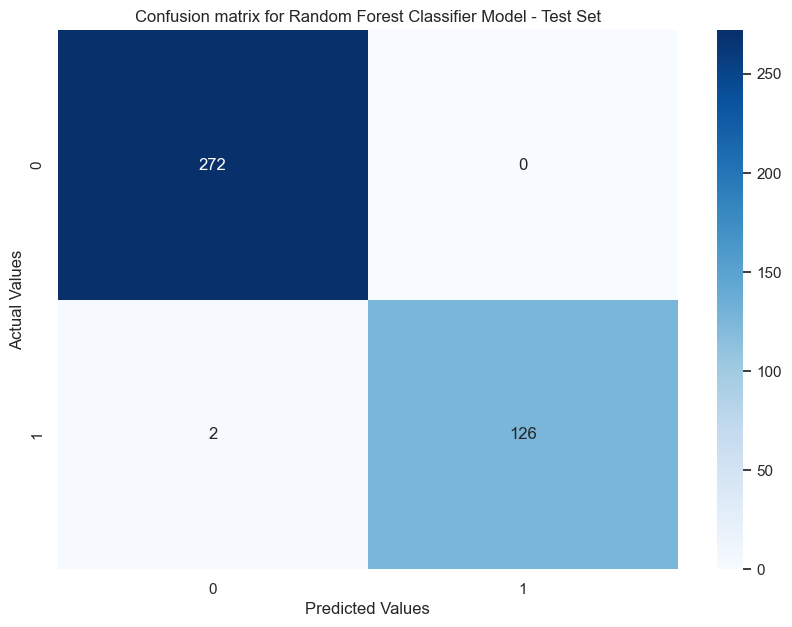

In [145]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [146]:
# Accuracy Score
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

Accuracy on test set: 99.5%


In [147]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       272
           1       1.00      0.98      0.99       128

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



In [148]:
# Creating a confusion matrix for training set
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[1044,    0],
       [   0,  556]], dtype=int64)

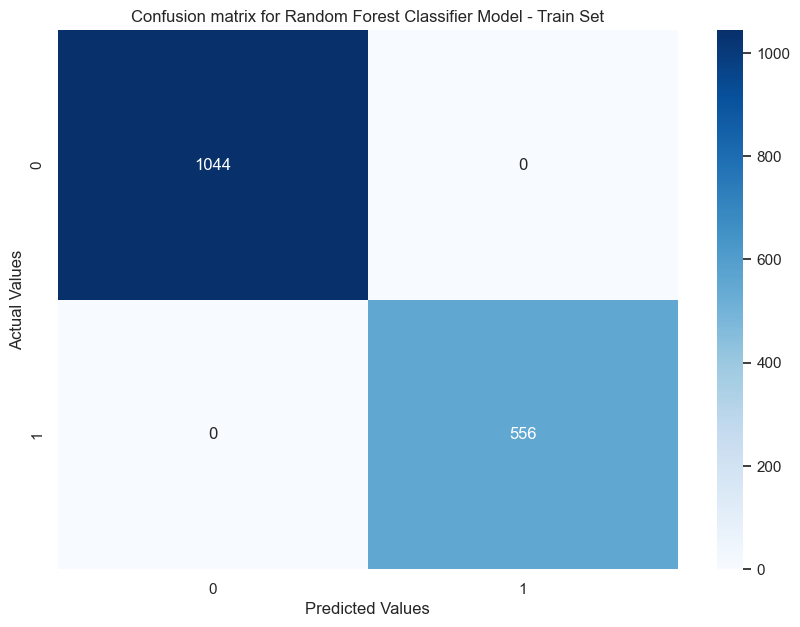

In [149]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [150]:

# Accuracy Score
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on trainning set: {}%".format(score))

Accuracy on trainning set: 100.0%


In [151]:
# Creating a function for prediction
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)

    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x = sc.transform(x)

    return classifier.predict(x)

In [152]:
# Prediction 1
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(2, 81, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


In [153]:
# Prediction 2
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(1, 117, 88, 24, 145, 34.5, 0.403, 40)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Oops! You have diabetes.


In [154]:
# Prediction 2
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(5, 120, 92, 10, 81, 26.1, 0.551, 67)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


In [155]:
import pickle
pickle.dump(classifier, open('diabetes-prediction-rfc-model.pkl', 'wb'))